# Computer Assignment 6 a1)
* Ali Bemani
* Oscar Bautista Gonzalez
* Martin Hellkvist

This document is structured like this:
* Problem setup (recap from CA5)
    * Describes the problem setup, cost functions and gradients
    * Preprocessing of data
    * Robustifications
* Quantization methods
* Summary of Results
* Implementation
The results and implementations for 6 a2) and the discussion for b) is included in the the second file ``CA-G2-6-a2-b.ipynb``.

#### Problem setup
The MNIST dataset is used to train a binary SVM classifier.
The dataset is restricted to only examples with labels "0" and "1", this way we only have two classes, and can use a binary SVM classifier.
The multiclass SVM classifier is an extension to this, but we ignore it for the sake of simplicity.

We transform the labels so that "0" is assigned -1, and "1" is assigned +1.
This enables us to define the objective function as
$$ L(w) = \frac{1}{N} \sum_{i\in [N]} L_i(w) + \lambda ||w||_2^2, $$
$$ L_i(w) = \max(0, 1 - y_i w^T x_i) $$
and we use the following subgradient for gradient descent:
$$ \partial L_i(w) = -y_i x_i, ~~\text{if}~~ 1 - y_i w^T x_i > 0,~~ \text{otherwise} ~~ \partial L_i(w) = 0 $$
so that the subgradient for $L$ becomes
$$ \partial L(w) = \frac{1}{N} \sum_{i\in[N]} \partial L_i(w) + 2\lambda w $$

## Preprocessing of data
After removing the examples with labels not "0" or "1" we do some preprocessing of the data.
Originally each example has the label together with an 28 by 28 array of pixels with values from 1 to 255.
We reorganize it so that each of these arrays is a $28^2=784$ vector scaled by $1/255$.
This scaling rescales the problem, and can give nicer numerical properties.
Then we append a new entry into each vector of value $1$, which enables the transformation $w^T x_i$ to be affine, rather than strictly linear.

## Distribution over workers
We then split the input data into a python list ``X`` with 10 elements.
Each element is a numpy array of shape ``(N,785)``, where ``N`` is the number of data used for training in each worker.
We also have the list ``Y`` which is also of 10 elements, but with numpy arrays of shape ``(N,1)``.

## Computation of gradients
The (sub)gradients are then computed in a distributed fashion like this
* For each worker ``i = 1, ..., 10``
    * ``g[i] = compute_gradient(w, X[i], Y[i])``
    
Then the parameters at the master is computed like ``w = w - alpha/N*(g[1] + ... + g[10])``.

# Quantization methods

The novelty of this assignment in compared with the previous one is based on the application of two quantization methods, Q1 and Q2.

(Q1) For the implementation of Q1, where we set $K$ values of a communicated vector to zero,
we randomly choose $K$ values of each vector to be zero in each iteration, for each vector.
We noted that with $K=0$, there are around 300-600 values in the gradients that are zero anyways.

This could be used in a clever way: count the number of values that are already zero as $n_z$, and then set $K-n_z$ to zero.
In this way we would save more information, than doing zeroforcing randomly!
With $K=700$ we increased the final test accuracy of Decentralized GD from 1027 to 1031 out of 1031 by doing this.
This describes the method we analyze in this document.

(Q2) Here we map any given value $x$ to the values in $\{-7\gamma, -6\gamma,\cdots, -\gamma, 0, \gamma, 2\gamma, \cdots, 8\gamma\}$ like follows:

* if $x > 8\gamma$: $Q(x) = 8\gamma$,
* else if $x < -7\gamma$: $Q(x) = -7\gamma$,
* else: suppose $ k \gamma \leq x \leq (k+1)\gamma$, then
    * $ Q(x) = k\gamma, ~ w.p. 1 - \frac{x - k\gamma}{\gamma}$,
    * $ Q(x) = (k+1)\gamma, ~ w.p. \frac{x - k\gamma}{\gamma}$.


# Summary of results

* Then, we have get results from two cases:
    * Q1: sparsifying the gradients, which depends on the number of elements set to 0 ($K$).
    * Q2: transform each gradient vector from float64 to int4.
    
Both methods have been applied on each gradient locally before transmission.

$Q1$:

A big value of $K$ such as 500 implies a small deterioration of the convergence, where the number of iterations that is needed to reach the same accuracy  is increased by 1.  
* Decentralized Gradient Descent $\alpha=7$:
  * K = 0, K = 250 
    * 1031 our of 1031 predictions,
    * 9 iterations,
    * 90 signaling exchanges, 
    * 508, 350 kB transmitted
    
  * K = 500
    * 1031 our of 1031 predictions,
    * 10 iterations,
    * 100 signaling exchanges.
    * 210 kB transmitted
    
  * K = 750
    * 1031 our of 1031 predictions,
    * 22 iterations,
    * 220 signaling exchanges.
    * 75 kB transmitted
    
Setting 250 elements of the gradient to 0, we require the same number of iterations to converge in compare to CA5a(K=0), but we send 30% less data. For higher values, more data can be saved but it has a computation cost.
    
$Q2$:

For this quantizer, we have set $\gamma$, which is the scale factor that defines the range for the quantizer of 4 bits. Then, the outputs from the quantizer can be:
  * $Q(g[i]) = {-\gamma*7, -\gamma*6, ..., \gamma*7, \gamma*8}$
  
* Decentralized Gradient Descent $\alpha=7$:
  * $\gamma=0.1$ 
    * 1031 our of 1031 predictions,
    * 12 iterations,
    * 120 signaling exchanges.
    * 42 kB transmitted
  * $\gamma=0.5$ 
    * 1031 our of 1031 predictions,
    * 30 iterations,
    * 300 signaling exchanges.
    * 106 kB transmitted
    
The quantizer $Q2$ requires a previous knowledge on the variable that is going to be quantize due to the scale factor. If we choose a no proper one, then the number of iterations can be aumented drastically.
  
The number of signals exchanged is described on CA5.

In [3]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt
import mnist
from PIL import Image

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

Failed on importing 'resource' package, continuing wihtout it!


# Load data

In [4]:
train_data = mnist.train_images()
train_labels = mnist.train_labels()
test_data = mnist.test_images()
test_labels = mnist.test_labels()

(N_train, d0, d1) = train_data.shape
(N_test, _, _) = test_data.shape
decrease_bool = True

## Extract labels 1 and 0, we will only use a binary SVM classifier.

In [5]:
if decrease_bool:
    indexes_0 = (train_labels == 0)
    indexes_1 = (train_labels == 1)

    indexes_0_or_1 = indexes_0 + indexes_1

    test_labels = test_labels[0:5000]
    test_data = test_data[0:5000]

    indexes_0_test = (test_labels == 0)
    indexes_1_test = (test_labels == 1)

    indexes_0_or_1_test = indexes_0_test + indexes_1_test

    train_data = train_data[indexes_0_or_1,:,:]
    train_labels = train_labels[indexes_0_or_1].astype('float64')
    train_labels[train_labels==0] = -1

    test_data = test_data[indexes_0_or_1_test,:,:]
    test_labels = test_labels[indexes_0_or_1_test].astype('float64')
    test_labels[test_labels==0] = -1
    decrease_bool = False

-1.0


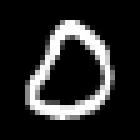

In [6]:
def print_image(idx, data, labels):
    scale= 5
    print(labels[idx])
    return Image.fromarray(np.repeat(np.repeat(data[idx,:,:], scale, axis=1), scale, axis=0))
N = train_data.shape[0]
idx = int(N*np.random.rand())
print_image(idx, train_data, train_labels)

(array([5923.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6742.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

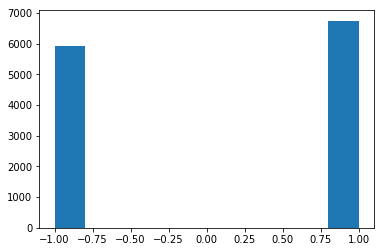

In [7]:
plt.hist(train_labels)

(array([460.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 571.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

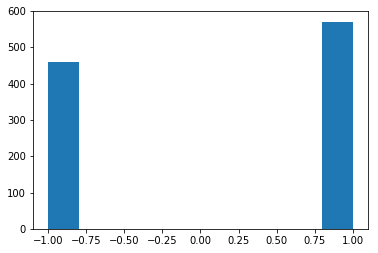

In [8]:
plt.hist(test_labels)

## Split into 10 random disjoint subsets

In [9]:
np.random.seed(0)
N_train = train_data.shape[0]
print(N_train)
N_data = test_data.shape[0]
N_workers = 10
N_train = N_train - N_train % N_workers
print(N_train)

indexes_ = np.random.choice(N_train, size=N_train, replace=False, p=None)
indexes_ = list(indexes_.reshape(10, -1))
X = [np.hstack((train_data[i].reshape(int(N_train/N_workers), -1)/255,np.ones((int(N_train/N_workers),1)))) for i in indexes_]
y = [train_labels[i].reshape(-1,1) for i in indexes_]

12665
12660


In [10]:
N_test = test_data.shape[0]
X_test = np.hstack((test_data.reshape(N_test, -1)/255,np.ones((N_test,1))))
y_test = test_labels.reshape(-1, 1)

# Gradient Solvers
The local function in worker $i$ to minimize is

$$ f_i(w) = \frac{1}{|D_i|} \sum_{(x,y)\in D_i} (y - w^T x)^2 $$

which has the gradient 

$$ \nabla f_i(w) =  \frac{2}{|D_i|} \sum_{(x,y)\in D_i} x (w^T x - y)  $$

### Compute Grad

In [11]:
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y*X # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T/N
    
    reg =  2*lambda_ * w
#     set_trace()

    return g + reg

### Compute hingeloss

In [12]:
def hinge_loss(w, X, Y):
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d,1)
    assert Y.shape == (N,1)
    L = 1 - Y * (X @ w) # (N,1)
    L[L < 0] = 0
    return L

### Cost

In [13]:
def cost(w, X, Y):
    return np.sum(hinge_loss(w,X,Y))

### Predict

In [14]:
def predict(w, X):
    return np.sign(X @ w)

### Accuracy

In [15]:
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects/N

### Quantization

In [33]:
range_q2 = np.arange(-7,8+1)
def quantize(v, K, q="Q1"):
    if (q == "Q1"):
        """ Set K values in v to zero """
        d, m = v.shape
        assert m == 1
        if K >= d:
            return np.zeros((d,1)) # this is 10x slower than  having a global variable for a zero vector
        else:
            idx_to_set_zero = np.random.choice(d, size=(K,1), replace=False) # this seems slow!
            v[idx_to_set_zero] = 0
            return v
        
    if (q == "Q1_1"):
        """ Set K values in v to zero """
        d, m = v.shape
        assert m == 1
        if K >= d:
            return np.zeros((d,1)) # this is 10x slower than  having a global variable for a zero vector
        else:
            number_of_zeros = np.sum(v == 0)
            k = np.max((0, K-number_of_zeros))
            if k > 0:
                idx_to_set_zero = np.random.choice(d, size=(k,1), replace=False) # this seems slow!
                v[idx_to_set_zero] = 0
            return v
        
    if (q == "Q2"):
#         """ Change type from float64 to int8 """
#         d, m = v.shape
#         assert m == 1
#         return v.astype('int8')
        d, m = v.shape
        assert m == 1
        R = K*range_q2
#         set_trace()
        for i in range(d):
            vi = v[i]
            k = np.max(np.where(vi > R)) - 7
            prob_k = 1 - (vi - k*K)/K
            if (np.random.rand() < prob_k):
                v[i] = k*K
            else:
                v[i] = (k+1)*K
        return v
            


### Def solver

In [47]:
def solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer = "DGD",
           quantizer="Q1", K=0, mem=False, return_cost=False, verbose=True, seed=-1):
    
    N_workers = len(X)
    dw = w.shape[0]
    
    if seed != -1:
        np.random.seed(seed)
    
    cost_ = np.zeros(num_iters+1)
    if return_cost:
        cost_[0] = accuracy(w, X_test, Y_test)
    
    if (optimizer == "DGD"): # Decentralized GD
        g_ = np.zeros(shape=(dw, N_workers))
        numitersstop = num_iters
        for i in range(num_iters):
            for worker_i in range(N_workers):
                gi = compute_gradient(w, X[worker_i], Y[worker_i], lambda_)    
                # quantize the gradient before sending:
                gi = quantize(gi, K, quantizer)
#                 set_trace()
                g_[:, worker_i] = gi.flatten()
                
            g = np.sum(g_, axis=1, keepdims=1)
            w = w - alpha * g/N_workers # GD update
            # We are not compressing the parameters w now
            
            gnorm = np.linalg.norm(g)
            if gnorm <= epsilon:
                print("Stopped gradient norm fulfilled")
                numitersstop = i
                break
            
            if return_cost:
                cost_[i+1] = accuracy(w, X_test, Y_test)
                
        if (verbose):
            print("DGD: Number of iterations: ", numitersstop, "/", num_iters)
            print("DGD: final norm: ", np.linalg.norm(g))
            
    return cost_, w

# Run SVM solver on data


## Q1

In [53]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,1)
alpha = 7
num_iters = 100
lambda_ = 0
epsilon = -1
time1 = time.time()
cost_DGD_q1, w_out_q1 = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer = "DGD",
          quantizer="Q1_1", K=750, mem=False, return_cost=True, verbose=True, seed=-1)
time2 = time.time()
print("Runtime DGD num_iters=", time2-time1)

DGD: Number of iterations:  100 / 100
DGD: final norm:  0.034501895424091336
Runtime DGD num_iters= 5.641052961349487


final cost 1.0
final acc: 1031.0 of 1031


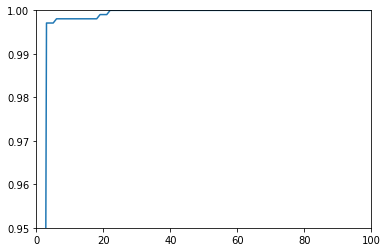

In [54]:
plt.plot(cost_DGD_q1)
print("final cost", cost_DGD_q1[-1])
plt.ylim(0.95,1)
plt.xlim(0,100)
acc_final = accuracy(w_out_q1, X_test, y_test)
print("final acc:", acc_final*N_test, "of", N_test)

## Q2

In [69]:
d = X[0].shape[1]
np.random.seed(3)
w = np.random.rand(d,1)
alpha = 7
num_iters = 100
lambda_ = 0
epsilon = -1
time1 = time.time()
cost_GD_q2, w_out_q2 = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer = "DGD",
          quantizer="Q2", K=.5, mem=False, return_cost=True, verbose=True, seed=-1)
time2 = time.time()
print("Runtime GD num_iters=", time2-time1)

DGD: Number of iterations:  100 / 100
DGD: final norm:  0.8660254037844386
Runtime GD num_iters= 25.77812671661377


final cost 1.0
number of ones guessed;  571
[[  56.73382502]
 [-104.8314969 ]
 [  69.4988635 ]
 ...
 [  45.74932008]
 [ -86.33599887]
 [-109.2761344 ]]
final acc: 1031.0 of 1031


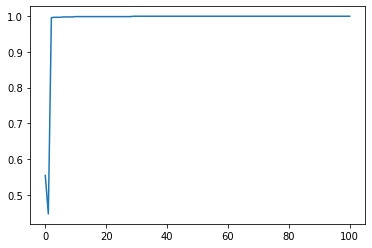

In [70]:
plt.plot(cost_GD_q2)
print("final cost", cost_GD_q2[-1])
# plt.ylim(0.95,1)
# plt.xlim(0,100)
pred = predict(w_out_q2, X_test)
print("number of ones guessed; ", np.sum(pred == 1))
print(X_test @ w_out_q2)
acc_final = accuracy(w_out_q2, X_test, y_test)
print("final acc:", acc_final*N_test, "of", N_test)

## Without Quantization, for reference:

In [80]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,1)

time1 = time.time()
cost_GD, w_out = solver(X, y, X_test, y_test, w, alpha, num_iters, lambda_, epsilon, optimizer = "DGD",
          quantizer="Q1", K=0, mem=False, return_cost=True, verbose=True, seed=-1)
time2 = time.time()
print("Runtime GD num_iters=", time2-time1)

DGD: Number of iterations:  100 / 100
DGD: final norm:  0.04416770164945651
Runtime GD num_iters= 8.084917068481445


final cost 1.0
final acc: 1031.0 of 1031


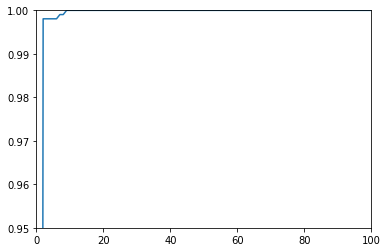

In [81]:
plt.plot(cost_GD)
print("final cost", cost_GD[-1])
plt.ylim(0.95,1)
plt.xlim(0,100)
acc_final = accuracy(w_out, X_test, y_test)
print("final acc:", acc_final*N_test, "of", N_test)